In [121]:
import torch
import sys
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import torchvision

sys.path.insert(0, "../../../")


# Evaluation mode

In [122]:
# package for download file from google drive
# ! pip uninstall gdown

In [123]:
# https://drive.google.com/file/d/1yEolUJYvk93S54c1b8zfE22ugVRy06GF/view?usp=drive_link
# "https://drive.google.com/uc?id=0B9P1L--7Wd2vVlpzRkwzYUladms"

In [124]:
folder_name = 'resnet_artefacts'
resnet_artefact_files = {'resnet18_pretrain_simclr':'1yEolUJYvk93S54c1b8zfE22ugVRy06GF',
                         'resnet18_finetune':'1N8CdPJSOBqlb2hzceztXyhrQrxXahg2M'}

In [125]:

# download and extract model files
# os.system('gdown https://drive.google.com/uc?id={}'.format(resnet_artefact_files['resnet18_finetune']))
# os.system('unzip {}'.format(folder_name))
# !ls

import gdown

drive_url = 'https://drive.google.com/file/d/1yEolUJYvk93S54c1b8zfE22ugVRy06GF/view?usp=drive_link'
url = 'https://drive.google.com/uc?id=1yEolUJYvk93S54c1b8zfE22ugVRy06GF'
output = 'resnet_pretrained.tar'
gdown.download(url, output, quiet=False)
# gdown.cached_download(url, output, postprocess=gdown.extractall)
! ls

Downloading...
From (uriginal): https://drive.google.com/uc?id=1yEolUJYvk93S54c1b8zfE22ugVRy06GF
From (redirected): https://drive.google.com/uc?id=1yEolUJYvk93S54c1b8zfE22ugVRy06GF&confirm=t&uuid=94e2055f-6676-4e9a-b04a-666c30168d01
To: /home/kgamegah/Documents/academic/UPC/DeepLearning/s3ima/s3ima/arch/SimCLR/prototype/resnet_pretrained.tar
100%|██████████| 138M/138M [00:03<00:00, 41.6MB/s] 


data  eval.ipynb  eval_runs  resnet_pretrained.tar


In [126]:
from s3ima.arch.ResNet18.model import ResNet18, BasicBlock
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
from torchvision import datasets
import torch
from collections import Counter
from sklearn.model_selection import train_test_split

In [127]:
mnist_train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

mnist_test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=False,
    transform=transforms.ToTensor()
)

print(len(mnist_train_dataset))
print(mnist_train_dataset.targets.numpy())
# sample100 = Subset(dataset=mnist_train_dataset,indices=)
Counter(mnist_train_dataset.targets.numpy())

60000
[5 0 4 ... 5 6 8]


Counter({1: 6742,
         7: 6265,
         3: 6131,
         2: 5958,
         9: 5949,
         0: 5923,
         6: 5918,
         8: 5851,
         4: 5842,
         5: 5421})

In [128]:
# sample 100 data with same classes proportion 
train_idx, validation_idx = train_test_split(np.arange(len(mnist_train_dataset)),
                                             train_size=100,
                                             random_state=1,
                                             shuffle=True,
                                             stratify=mnist_train_dataset.targets.numpy())
# Subset dataset for train and val
train_dataset = Subset(mnist_train_dataset, train_idx)


train_loader = DataLoader(train_dataset, 
                          batch_size=10,
                          num_workers=8, 
                          drop_last=False, 
                          shuffle=True)

test_loader = DataLoader(mnist_test_dataset, 
                         batch_size=256,
                         num_workers=8, 
                         drop_last=False, 
                         shuffle=True)

# Counter(train_dataset.targets.numpy())
# train_loader.batch_size

In [129]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Using device: cpu


In [130]:
checkpoint = torch.load('resnet_pretrained.tar', map_location=device)
state_dict = checkpoint['state_dict']

for k in list(state_dict.keys()):

    if k.startswith('backbone.'):
        if k.startswith('backbone') and not k.startswith('backbone.fc'):
            # remove prefix
            state_dict[k[len("backbone."):]] = state_dict[k]
    del state_dict[k]

In [131]:
model = ResNet18(num_layers=18,
                  block=BasicBlock,
                  num_classes=10,
                  grayscale=True)
model.to(device=device)


log = model.load_state_dict(state_dict, strict=False)
assert log.missing_keys == ['fc.weight', 'fc.bias']


In [132]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0008)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [133]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [134]:
epochs = 100
for epoch in range(epochs):
    top1_train_accuracy = 0
    for counter, (x_batch, y_batch) in enumerate(train_loader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        top1 = accuracy(logits, y_batch, topk=(1,))
        top1_train_accuracy += top1[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    top1_train_accuracy /= (counter + 1)
    top1_accuracy = 0
    top5_accuracy = 0
    for counter, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(x_batch)

        top1, top5 = accuracy(logits, y_batch, topk=(1,5))
        top1_accuracy += top1[0]
        top5_accuracy += top5[0]

    top1_accuracy /= (counter + 1)
    top5_accuracy /= (counter + 1)
    print(f"Epoch {epoch}\t"
          f"Top1 Train accuracy {top1_train_accuracy.item()}\t"
          f"Top1 Test accuracy: {top1_accuracy.item()}\t"
          f"Top5 test accuracy: {top5_accuracy.item()}")

Epoch 0	Top1 Train accuracy 44.0	Top1 Test accuracy: 71.865234375	Top5 test accuracy: 95.986328125
Epoch 1	Top1 Train accuracy 88.0	Top1 Test accuracy: 86.484375	Top5 test accuracy: 98.779296875
Epoch 2	Top1 Train accuracy 95.0	Top1 Test accuracy: 89.365234375	Top5 test accuracy: 99.3359375
Epoch 3	Top1 Train accuracy 98.0	Top1 Test accuracy: 91.23046875	Top5 test accuracy: 99.4140625
Epoch 4	Top1 Train accuracy 99.0	Top1 Test accuracy: 91.650390625	Top5 test accuracy: 99.501953125
Epoch 5	Top1 Train accuracy 100.0	Top1 Test accuracy: 91.787109375	Top5 test accuracy: 99.501953125
Epoch 6	Top1 Train accuracy 99.0	Top1 Test accuracy: 91.9140625	Top5 test accuracy: 99.55078125
Epoch 7	Top1 Train accuracy 100.0	Top1 Test accuracy: 92.4609375	Top5 test accuracy: 99.51171875
Epoch 8	Top1 Train accuracy 100.0	Top1 Test accuracy: 92.451171875	Top5 test accuracy: 99.51171875
Epoch 9	Top1 Train accuracy 100.0	Top1 Test accuracy: 93.02734375	Top5 test accuracy: 99.53125
Epoch 10	Top1 Train accura

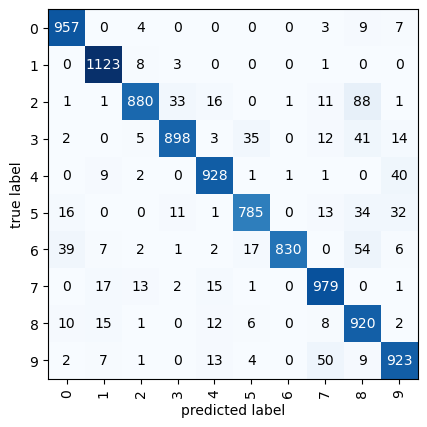

In [135]:
from s3ima.arch.SimCLR.helper_plotting import plot_confusion_matrix
from s3ima.arch.SimCLR.helper_evaluation import compute_confusion_matrix

class_dict = {0: '0',
              1: '1',
              2: '2',
              3: '3',
              4: '4',
              5: '5',
              6: '6',
              7: '7',
              8: '8',
              9: '9'}

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values(), results_dir='./figures')
plt.show()

In [120]:
# 
# from torch.utils.tensorboard import SummaryWriter
# from s3ima.arch.SimCLR.helper_config import save_config_file, save_checkpoint
# import logging
# 
# def train_then_eval_model(model,
#                           optimizer,
#                           # scheduler,
#                           train_loader,
#                           valid_loader,
#                           # test_loader,
#                           args=None,
#                           criterion=None):
# 
#     writer = SummaryWriter(log_dir='eval_runs')
#     # config logging file
#     logging.basicConfig(filename=os.path.join(writer.log_dir, 'eval.log'),
#                         level=logging.DEBUG)
#     # save config file
#     # save_config_file(writer.log_dir, args)
#     
#     epochs = 100
#     
#     loss_hist_train = [0] * epochs
#     loss_hist_valid = [0] * epochs # args.train_epochs
#     acc_hist_train = [0] * epochs
#     acc_hist_valid = [0] * epochs # args.train_epochs
#     
#     # minibatch summary
#     minibatch_hist_train_loss = []
#     minibatch_hist_train_acc = []
# 
#     global_step = 0
# 
#     for epoch in range(epochs):
#         model.train()
# 
#         for x_batch, y_batch in train_loader:
#             optimizer.zero_grad()
# 
#             pred = model(x_batch)
#             loss = criterion(pred, y_batch)
#             loss.backward()
#             optimizer.step()
# 
#             
#             is_correct = (torch.argmax(input=pred, dim=1) == y_batch).float()
#             accuracy = (is_correct.sum())
#             minibatch_acc = accuracy / y_batch.size(0)
#             minibatch_loss = loss.item()
# 
#             # minibatch summary
#             minibatch_hist_train_loss.append(minibatch_loss)
#             minibatch_hist_train_acc.append(minibatch_acc)
#             
#             # Enregistrement à chaque itération (minibatch)
#             writer.add_scalar(tag='train/loss', scalar_value=minibatch_loss, global_step=global_step)
#             writer.add_scalar(tag='train/acc', scalar_value=minibatch_acc, global_step=global_step)
#             # writer.add_scalar(tag='learning_rate', scalar_value=scheduler.get_lr()[0], global_step=global_step)
# 
#             global_step += 1  # Mettre à jour le compteur global
#             
#             # epochs summary
#             loss_hist_train[epoch] += minibatch_loss * y_batch.size(0)
#             acc_hist_train[epoch] += accuracy
# 
#         # epochs summary
#         loss_hist_train[epoch] /= len(train_loader.dataset)
#         acc_hist_train[epoch] /= len(train_loader.dataset)
#         
#         # add writer for epochs for needs
#         
#         if valid_loader is not None:
# 
#             # Évaluation à chaque époque
#             model.eval()
#             with torch.no_grad():
#                 for x_batch, y_batch in valid_loader:
#                     pred = model(x_batch)
#                     loss = criterion(pred, y_batch)
#                     loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
#                     is_correct = (torch.argmax(input=pred, dim=1) == y_batch).float()
#                     acc_hist_valid[epoch] += is_correct.sum()
#             loss_hist_valid[epoch] /= len(valid_loader.dataset)
#             acc_hist_valid[epoch] /= len(valid_loader.dataset)
# 
#             writer.add_scalar(tag='valid/loss', scalar_value=loss_hist_valid[epoch], global_step=global_step)
#             writer.add_scalar(tag='valid/acc', scalar_value=acc_hist_valid[epoch], global_step=global_step)
# 
#             print(f'Epoch {epoch +1} '
#                   f'val_loss: {loss_hist_valid[epoch]: .4f} '
#                   f'val_acc: {acc_hist_valid[epoch]: .4f} '
#                   f'val_num_test_data: {len(test_loader.dataset)} '
#                   f'val_num_train_data: {len(train_loader.dataset)} ')
# 
#     logging.info("Training has finished.")
#     # save model checkpoints
#     # checkpoint_name = f'{args.arch}_finetune_{epochs:04d}.pth.tar'
#     #save_checkpoint(state={'epoch': epochs,
#     #                       'arch': args.arch,
#     #                       'state_dict': model.state_dict(),
#     #                       'optimizer': optimizer.state_dict(),
#     #                       },
#     #                is_best=False,
#     #                filename=os.path.join(writer.log_dir, checkpoint_name))
#     #logging.info(f"Model checkpoint and metadata has been saved at {writer.log_dir}.")

In [119]:
# train_then_eval_model(model=model,optimizer=optimizer,train_loader=train_loader,valid_loader=test_loader,criterion=criterion)